0.0
0.034206489646438264
-0.034206489646438264

0.0
0.004402200228547612
-0.004402200228547612

0.0
0.0008459306885088756
-0.0008459306885088756

0.0
0.14190899311513624
-0.14190899311513624

0.0
0.13734454092048906
-0.13734454092048906

0.0
0.059386932397147346
-0.059386932397147346

0.0
0.009162676303891155
-0.009162676303891155

0.0
0.013011010836859212
-0.013011010836859212

0.002291358389096529
0.110753384174537
-0.10846202578544048

0.002291358389096529
0.03472649381288582
-0.03243513542378929

0.002291358389096529
0.03766348804712627
-0.035372129658029744

0.002291358389096529
0.007710846119428228
-0.0054194877303316985

0.009257317027788895
0.12648628390413716
-0.11722896687634826

0.009257317027788895
0.1536914429378914
-0.1444341259101025

0.009257317027788895
0.02980389738779436
-0.020546580360005465

0.009257317027788895
0.06866229750725623
-0.05940498047946734

0.021038120820553584
0.1287797043954645
-0.1077415835749109

0.021038120820553584
0.01772940543616752
0.003308715

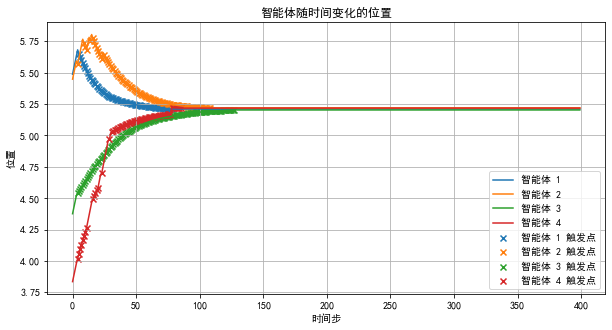

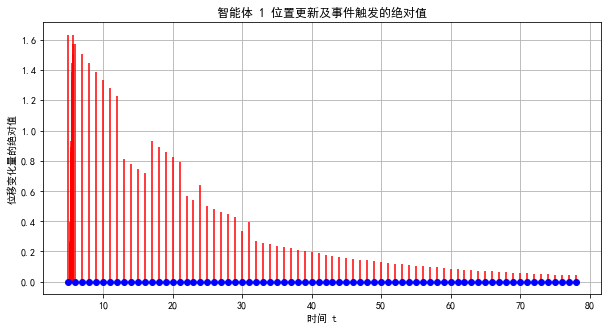

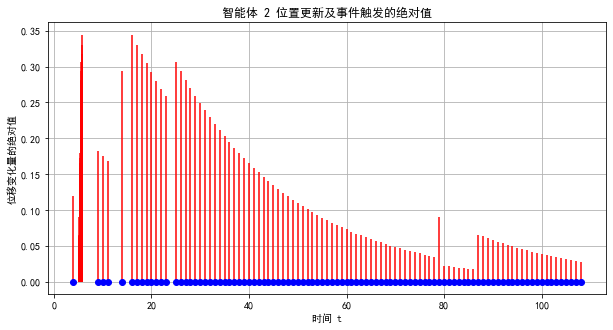

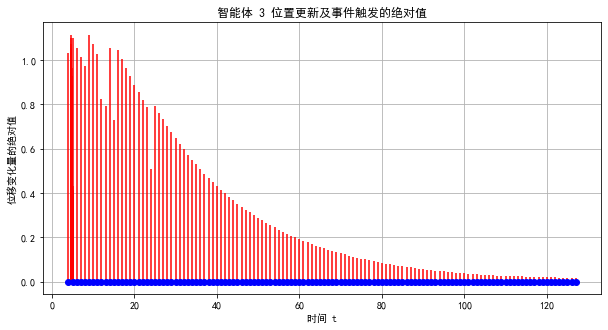

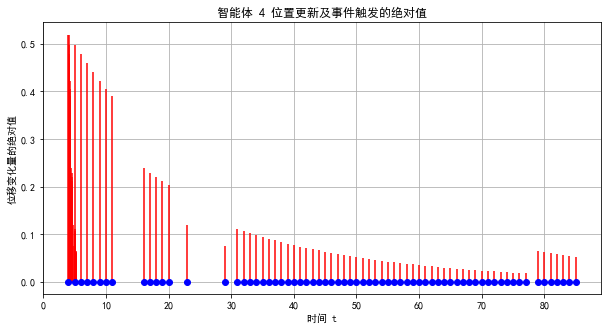

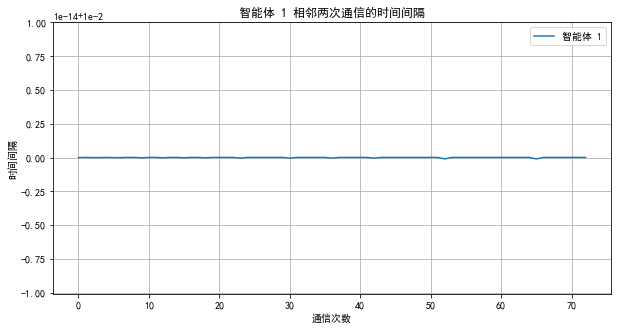

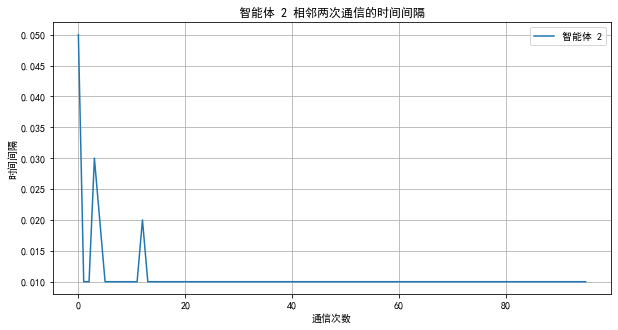

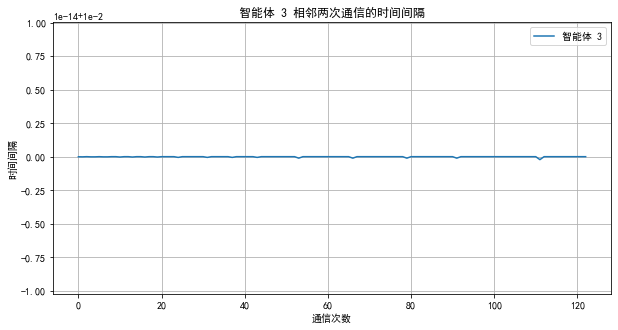

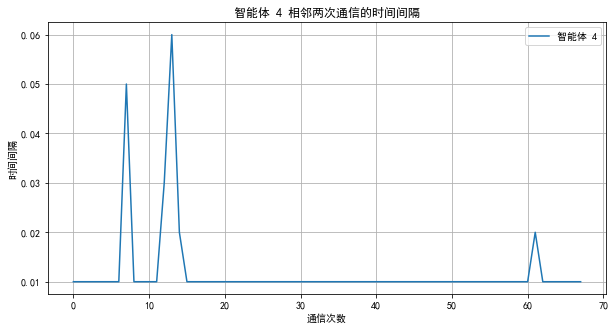

In [47]:
import numpy as np
import matplotlib.pyplot as plt


class Agent:
    def __init__(self, initial_position, index):
        self.position = initial_position
        self.index = index
        self.neighbors = []
        self.last_broadcast_position = self.position  #存储了该智能体最近一次广播的位置
        self.sigma = np.random.uniform(0, 1)
        self.alpha = np.random.uniform(0, 1 / max(1, len(self.neighbors)))  # 另一个触发函数参数
        self.trigger_points = []
        self.trigger_points2 = []  # 用于记录事件触发时的位置
        self.delta_positions = []
        self.last_trigger_time = 0  # 初始化上次触发时间
        self.MIET = 10 * dt  # 设定最小触发间隔，根据需求调整
        self.communication_times = []  # 记录每次通信的时间
        

    def add_neighbor(self, neighbor):
        if neighbor not in self.neighbors:
            self.neighbors.append(neighbor)
            neighbor.neighbors.append(self)

    def is_neighbor(self, agent):
        return agent in self.neighbors
    
    def get_position(self):
        return self.position
    
    def broadcast_position(self):
        # 广播当前位置给所有邻居
        for neighbor in self.neighbors:
            neighbor.last_broadcast_position = self.position
        
    def update_position(self, t, dt, current_average_position):
        self.sigma = np.random.uniform(0, 1)
        self.alpha = np.random.uniform(0, 1 / max(1, len(self.neighbors)))
        
        e_i = self.last_broadcast_position - self.position

        z_bar_squared = - sum(self.is_neighbor(neighbor) * (self.position - neighbor.get_position()) for neighbor in self.neighbors)

        
            
        trigger_condition = e_i ** 2 - self.sigma * self.alpha * (1 - self.alpha * max(1, len(self.neighbors))) * z_bar_squared ** 2  / max(1, len(self.neighbors))

        print(e_i ** 2)
        print(self.sigma * self.alpha * (1 - self.alpha * max(1, len(self.neighbors))) * z_bar_squared ** 2  / max(1, len(self.neighbors)))
        #print(self.alpha * max(1, len(self.neighbors)))
        print(trigger_condition)
        print()
        
        if (t - self.last_trigger_time) >= self.MIET and abs(self.position - current_average_position) > 0.01: 
            # 如果事件触发函数大于等于0，则更新位置并广播新位置
            if trigger_condition >= 0:
                #print(e_i ** 2)
                #print(self.sigma * self.alpha * (1 - self.alpha * max(1, len(self.neighbors))) * z_bar_squared ** 2  / max(1, len(self.neighbors)))
                #print(self.alpha * max(1, len(self.neighbors)))
                #print(trigger_condition)
                #print("1")
                
                #print()

                self.position += z_bar_squared * dt
                
                #记录触发的相关信息
                self.delta_positions.append(self.last_broadcast_position - self.position)
                self.trigger_points2.append(t * dt)
                self.trigger_points.append((t, self.position))
                self.broadcast_position()

                self.last_trigger_time = t
                self.communication_times.append(t * dt)
                
                
            else:
                self.position += current_average_position * dt
                #self.position += np.random.uniform(-1, 1) * dt
                #self.last_trigger_time = current_time
                #self.position += z_bar_squared * dt
                #self.last_broadcast_position = self.position
                #print("nonononononono")
                #print(e_i ** 2)
                #print(self.sigma * self.alpha * (1 - self.alpha * max(1, len(self.neighbors))) * z_bar_squared ** 2  / len(self.neighbors))
                #print(self.alpha * max(1, len(self.neighbors)))
                #print(trigger_condition)
                #print(current_time)
                
                #print("222222222222222222222")
                #print()
        #print(t)
        #print(self.last_trigger_time)
        #print(t - self.last_trigger_time)
        #print(self.MIET)
        #print()


            

# 初始化参数和智能体
num_agents = 4
num_iterations = 400
dt = 0.01
np.random.seed(0)
agents = [Agent(np.random.rand() * 10, i) for i in range(num_agents)]

# 定义邻居关系
agents[0].add_neighbor(agents[1])
agents[0].add_neighbor(agents[2])
agents[0].add_neighbor(agents[3])
agents[2].add_neighbor(agents[3])
agents[1].add_neighbor(agents[3])
agents[2].add_neighbor(agents[1])



# 运行模拟
positions = np.zeros((num_iterations, num_agents))

for t in range(num_iterations):
    current_average_position = np.mean([agent.position for agent in agents])
    #print(current_average_position)
    for agent in agents:
        agent.update_position(t, dt, current_average_position)
        positions[t, agent.index] = agent.position

# 绘制结果图
plt.figure(figsize=(10, 5))
for i, agent in enumerate(agents):
    plt.plot(positions[:, i], label=f'智能体 {i+1}')
    # 绘制事件触发点
    if agent.trigger_points:
        trigger_times, trigger_positions = zip(*agent.trigger_points)
        plt.scatter(trigger_times, trigger_positions, marker='x', label=f'智能体 {i + 1} 触发点')

plt.xlabel('时间步')
plt.ylabel('位置')
plt.title('智能体随时间变化的位置')
plt.legend()
plt.grid(True)


for index, agent in enumerate(agents):
    plt.figure(figsize=(10, 5))
    
    # Iterate over the agent's recorded trigger points and corresponding position changes
    for trigger_time, delta_position in zip(agent.trigger_points, agent.delta_positions):
        # Only if there is a change, i.e., delta_position is not zero
        if delta_position != 0:
            # Compute the absolute value of the position change
            absolute_delta = abs(delta_position)
            # Plot a vertical line from 0 to the absolute change value at the trigger time
            plt.vlines(trigger_time, 0, absolute_delta, colors='r')
            # Plot a blue dot at the bottom (x-axis) of the line
            plt.plot(trigger_time[0], 0, 'bo')  # Blue dot at the x-axis

    plt.xlabel('时间 t')
    plt.ylabel('位移变化量的绝对值')
    plt.title(f'智能体 {index + 1} 位置更新及事件触发的绝对值')
    plt.grid(True)


for agent in agents:
# 计算相邻两次通信的时间间隔
    if agent.communication_times:
        intervals = np.diff(agent.communication_times)  # 使用np.diff计算相邻元素的差值，即时间间隔
        plt.figure(figsize=(10, 5))
        plt.plot(intervals, label=f'智能体 {agent.index + 1}')
        plt.xlabel('通信次数')
        plt.ylabel('时间间隔')
        plt.title(f'智能体 {agent.index + 1} 相邻两次通信的时间间隔')
        plt.legend()
        plt.grid(True)
        plt.show()

    # 解决中文显示问题
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为黑体
    plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号 '-' 显示为方块的问题

    plt.show()